In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Non-default package
import SALib.sample.sobol_sequence as sobol

# (What I've learned about) Quasi-Monte Carlo

## Caroline (Ruoyi) Lin, for Reading Course on Monte Carlo Methods
## First draft Feb 27 2019, published March 9 2019


## Sources:

Christine Lemieux's Springer textbook on QMC methods: https://www.springer.com/gp/book/9780387781648

The Review paper I found : https://doi.org/10.1017/S0962492913000044

The 'Evaluation of 360-dimensional Mortgages' Whitepaper: https://doi.org/10.21314/JCF.1997.005

And some code for the Sobol sequence from: https://salib.readthedocs.io/en/latest/

## Original Motivations:
- Why is QMC considered a viable option for high-dimensional integrals?
- Motivating Case study: QMC on the Evaluation of 360-dimensional Mortgages 
- Why was QMC a viable option here?

## Overview of QMC 
Reference: Chapter 5 of the QMC Methods book by Lemieux.


Notation and Preamble:
- Generally speaking, $s$ is the number of dimensions in the hypercube $[0,1)^s$.
- We'd like to generate vectors $u$ of length $s$, where $s$ is a high number. The distribution of $u_i$ should be the same as the uniform distribution.
- Points are deterministically generated. The difference between these and pseudo-RNGs is somewhat subtle since pRNGs are also deterministic, but the idea is that points from QMC are more 'regular' in some formal sense, using either the *discrepancy* or *equidistribution* measures.
- Uniform points generated by a PRNG may have asymptotic density equal to the uniform distribution, but QMC points are expected to have uniform dispersion in $[0,1)^s$ for even low sample sizes.
- Once we have a method of generating random vectors $u$, the framework of calculating expectations of random variables is the same simulation framework as with pRNG points.

## First Class of QMC methods: Lattice points.

Lattice point methods are methods with low *discrepancy*.

### A Quick Discrepancy Primer

Discrepancy measures how close a discrete set of points is to being uniform.

In 1 Dimension ($s = 1$):

Let $P_n$ be a partition of the unit interval with $n$ points (ie. a set of $n$ points). The 1D discrepancy $D^*(P_n)$ is defined as

$$D^*(P_n) := \sup_{x \in [0, 1)} | F(x) - \hat{F}_n(x) |$$

where $F(x)$  is the CDF of a uniform R.V over the unit interval, and 

$$\hat{F}_n(x) := \frac{1}{n} \sum_{u_i \in P_n}^n 1_{u_i \leq x}$$

is the empirical CDF generated by $P_n$. See 5.1 of Lemieux.

Intuitively, $\hat{F}_n(x)$ gives the proportion of points in $P_n$ which are contained in the subinterval $[0, x)$, which seems like a natural way of inducing a CDF on a point set. Prof. Stinchcombe notes that this definition of discrepancy is the same as the *Kolmogorov-Smirnoff distance*.

In higher dimensions:

One generalization of discrepancy to higher dimensions is the *star discrepancy*:

$$D^*(P_n) \sup_{v \in [0, 1)^s} | F(v) - \hat{F}_n(v) |$$

where $F(v)$ is the volume of a hyperrectangle $R$ from the origin with side lengths $(v_1, \ldots, v_s)$, and $\hat{F}_n(v)$ is the empirical CDF generated by $P_n$, i.e. the proportion of points in $P_n$ which are contained in $R$. I've changed notation from Lemieux's to make the analogue between star discrepancy and 1D discrepancy more clear.

It's possible to compute 1D discrepancy with a simple code: the greatest difference in the uniform CDF and an induced CDF will occur at the locations where the $u_i$ are, so we only need to take the max over finitely many points.

In [54]:
import numpy as np

def calculate_discrepancy(X):
    '''Calculate the discrepancy of the point set X, assuming 
        that it is sorted in increasing order.'''
    
    if X[0] < 0 or X[-1] > 1:
        print("Invalid X")
        return 
    
    n = len(X)
    
    proportions = (1. / n ) * np.arange(1, n + 1)
    left_proportions = (1. / n ) * np.arange(0, n)
    
    discrepancies = X - proportions
    left_discrepancies = X - left_proportions
    
    discrepancy = np.max(np.abs(discrepancies))
    left_discrepancy = np.max(np.abs(left_discrepancies))
    
    #print(f'right and left discrepancies: {discrepancy} {left_discrepancy}')
    return max(discrepancy, left_discrepancy)

'''Examples from 5.1, p.140 of Lemieux.'''
n = 10 # Pick a particular value of n.

X = np.linspace(0, 1, n + 1)[:-1]
res = calculate_discrepancy(X) # Expected: 1/n = 0.1
print(res)

Y = np.linspace(0.5 * (1. / n), 1 - 0.5 * (1. / n), n)
res = calculate_discrepancy(Y) # Expected: 1/2n = 0.05
print(res)

'''Other test cases'''
Z = np.array([1.]) # Expected: 1.0
res = calculate_discrepancy(Z)
print(res)

0.10000000000000009
0.050000000000000155
1.0


## Lattice Points QMC 

The most basic lattice point method generates a set of points $P_n$ by using a scaled version of the integer grid in $\mathbb{R}^s$.

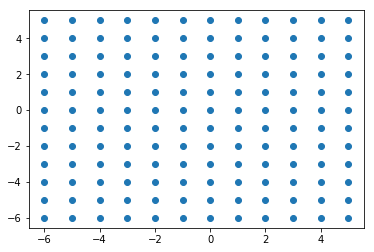

In [3]:
'''Overcomplicated integer lattice code'''

import numpy as np
import matplotlib.pyplot as plt

n = 6 # Number of points total
s = 2 # Number of dimensions

def LazyIntegerLattice(n, s):
    '''Generate an integer lattice
    Tries to make sure there are 2**s * n points total = 4n in 2 dimensions.
    '''
    n_per_dimension = int(np.ceil(np.log(n) / np.log(s)))
    dimension_ranges = [ list(range(-n_per_dimension, n_per_dimension)) for i in range(s) ] 
    lattice_pts = np.array(list((map(np.array, itertools.product(*dimension_ranges)))))
    return lattice_pts
        
res = LazyIntegerLattice(n ** s, s)
plt.scatter(res[:,0], res[:,1])

We can also apply a linear transformation to the grid. The number of points in the unit hypercube is $\frac{1}{|det(W)|}$, where $W$ is the matrix representation of the linear transformation (Lemieux 5.3). So if we want a partition $P$ of $n$ points, we should use $W$ with $|det(W)| = \frac{1}{n}$.

*Korobov point sets* use a transformation whose first row $w_1$ is given by

$$w_1 = \frac{1}{n} (1, a, a^2 \mod n, \ldots, a^{s-1} \mod n)$$ 

where $a$ is some integer between 1 and $n-1$ referred to as the *generator*. For $i \neq 1$, $w_i = e_i$. 

A more explicit equation gives the $i$-th Korobov point as

$$u_i = \frac{i}{n} (1, a, a^2 \mod n, \ldots, a^{s-1} \mod n) \mod 1$$

where the index $i$ starts from 0. Choosing $a$ to be relatively prime to $n$ (and not equal to 1) may prevent points from being 'projection irregular', which is when the projection of $P_i$ into any $k$-dimensional subspace is not injective. 

Not all relatively prime $a$ lead to low-discrepancy point sets. Lemieux gives some literature references for how to choose $a$.

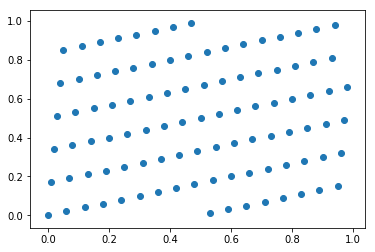

In [4]:
''' Adapted from p.149 formula, or else Fig 5.6. '''

def InitKorobov(a, n, s):
    z = np.zeros(s)
    z[0] = 1.
    for j in range(1, s): # 'prevent overflow'
        z[j] = (a * z[j - 1]) % n
        
    return z / n

def NextKorobov(n, z, u):
    return ((u + z) % 1)

def GenKorobov(a, n, s):
    pts = []
    
    u = np.zeros(s)
    z = InitKorobov(a, n, s)
    for i in range(1, n):
        pts += [u]
        u = NextKorobov(n, z, u)
    return pts

u = np.array(GenKorobov(17, 100, 2))
plt.scatter(u[:,0], u[:,1])


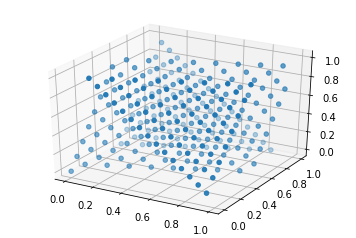

In [5]:
import numpy as np
u = np.array(GenKorobov(17, 256, 3))


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(u[:,0], u[:,1], u[:,2])

## Second Class of QMC methods: Digital nets and Sequences

For more details, see Lemieux 6.4. One of the simplest digital nets, conceptually, is the Halton sequence. 

We define the radical inverse function $\phi_b$, for a base $b$, as the function which reverses the digits of a number $n \in \mathbb{N}$'s base $b$ representation. Lemieux writes

$$\phi_b(n) = \sum_{l = 0}^{\infty} a_l(n) b^{-l-1}$$

where $a_l(n)$ is the $l$-th digit of $n$ in base $b$, but I think this overcomplicates things, since we can program $\phi_b$ as a one-liner in Python and MATLAB.

In [6]:
def radical_inverse(num):
    '''Radical inverse function for base b = 10.
    Other bases can be done easily too.
    '''
    s = str(num)
    ss = num[::-1] # reverse the string
    return ss

print(radical_inverse('1.234')) # Expected: 432.1
print(radical_inverse('01.23')) # Expected: 32.10

432.1
32.10


The Halton sequence generates a length $s$ vector $u$, with the $i$th such vector $u_i$ given by

$$u_i = (\phi_{b_1}(i), \ldots, \phi_{b_s}(i)), i \geq 0$$

$b_j$ is the $j$-th prime number. The Halton sequence is an early *digital sequence*. It has bad space filling properties for larger $s$ because the $b_s$ get quite large. See Fig 5.7 of Lemieux.

An alternative to the Halton sequence is to use the same base $b$ for each coordinate of $u_i$. However, if we choose to do this, we must alter the input to $\phi_b$ somehow between the coordinates of $u_i$ so that our coordinates are not all identical.

The easiest solution is to linearly transform the digits of the input $n$ in base $b$ before feeding it into $\phi_b$, and to use a different linear transformation for each coordinate of $u_i$. This is the definition of a digital filter.

A *digital net* is similar to a digital filter, except that we truncate $n$'s digital representation after a finite number of digits before applying linear transformations.

As a QMC method, digital nets and filters may have good discrepancy properties. There is another measure of uniformity which they can also satisfied, called *equidistribution*. 

A working definition for *equidistribution* for the point set $P_n$ is to divide the unit hypercube into $q$ equally-sized rectangles, and to check that each of the rectangles contains an equal number of points from the point set. See Ch. 3 of Lemieux.

The Sobol' sequence is one well-known type of digital net, and uses the radical inverse function with base $b=2$. Another related sampler is the 'Latin Hypercube sampler'.

The Sobol' sequence is somewhat involved to implement, so I've borrowed an implementation from a Python sensitivity analysis library here.

Rmk: Applications given in Lemieux show that naive implementations of QMC algorithms don't necessarily outperform a typical PRNG and may do worse.

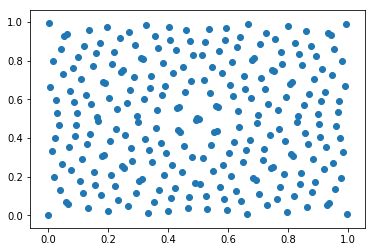

In [16]:
''' 1024 points from a 2D Sobol' sequence'''

import SALib.sample.sobol_sequence as sobol
import matplotlib.pyplot as plt

n = 256
s = 2
pts = sobol.sample(n,s) # first n pts in s dimensions

plt.scatter(pts[:n,0], pts[:n,1]) # plot the first n pts


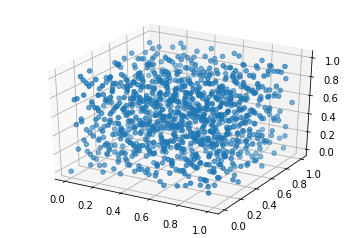

In [8]:
'''3D Slice of a 50-dimensional Sobol' sequence '''

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

hi_dim_pts = sobol.sample(1024, 50)

ax.scatter(hi_dim_pts[:,0], hi_dim_pts[:,1], hi_dim_pts[:,2]) # yay

# Experiment: Measuring Discrepancy

Here we compare the (1D) discrepancy some of the QMC sets we've discussed, vs the discrepancy of points sampled from a uniform pRNG.


# 1D Discrepancy plots


In [72]:
import numpy as np

N = 2 ** 10

uniform_d = []

'''One disadvantage of the set 1/n, 2/n ... (n-1)/n is that it needs to be regenerated
whenever we pick a new n. The following code is extremely inefficient.'''
for n in range(1, N + 1):
    uniform_set = np.linspace(0.5 * (1. / n), 1 - 0.5 * (1. / n), n)
    uniform_d += [calculate_discrepancy(uniform_set)] 



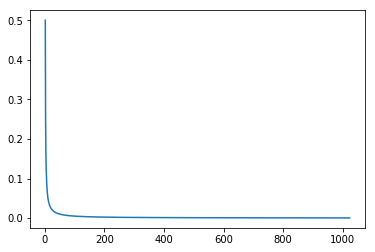

In [73]:
plt.plot(np.arange(1, N + 1), uniform_d)

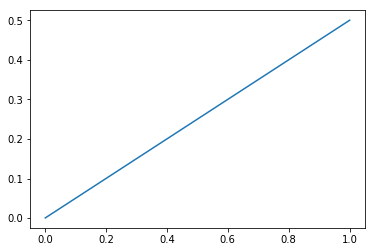

In [74]:
plt.plot(1. / np.arange(1, N+1), uniform_d)

The discrepancy of the uniform-shifted set is $\frac{1}{2N}$.

In [92]:
sobol_pts = []

import SALib.sample.sobol_sequence as sobol

'''The Sobol points don't suffer from this issue--
the first 512 Sobol points in a set of 1024 Sobol points
is the same as the first 512 for a set of 512 Sobol points.'''
sobol_pts = sobol.sample(N, 1)

sobol_discrep = []
for n in range(2, N + 1):
    # Sort the points before passing into discrepancy function
    # A much faster way to do this would to be maintain a balanced BST and insert new sobol points
    
    sorted_first_n_sobol = sobol_pts[1:n].reshape(-1)
    sorted_first_n_sobol.sort()
    
    sobol_discrep += [ calculate_discrepancy(sorted_first_n_sobol) ]
    

Somewhat annoyingly the discrepancy of the Sobol' sequence is $\frac{1}{n}$ because the 0 point is always included.

Cheating a little, we discard the origin and plot the discrepancy for the remaining $N-1$ points in the Sobol' sequence.

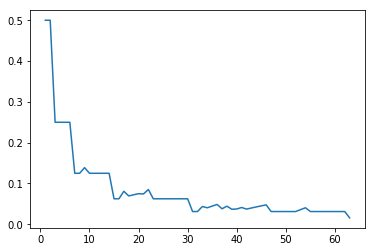

In [94]:
plt.plot(np.arange(1, N), sobol_discrep)

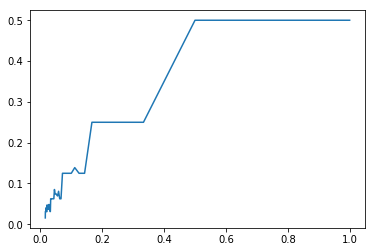

In [96]:
plt.plot(1. / np.arange(1, N), sobol_discrep)

Now we get discrepancies comparable to the shifted uniform set with plateaus.

Finally, let's compute the discrepancy of a pRNG set.

In [ ]:

np.random.seed(0)
rng_points = np.random.rand(N)

rng_sample_discrep = []
for n in range(1, N + 1):
    sorted_first_n_rand = rng_points[:n].reshape(-1)
    sorted_first_n_rand.sort()
    
    rng_sample_discrep += [ calculate_discrepancy(sorted_first_n_rand) ]


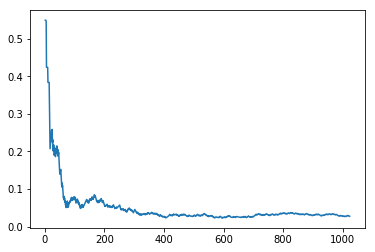

In [79]:
plt.plot(np.arange(1, N+1), rng_sample_discrep)

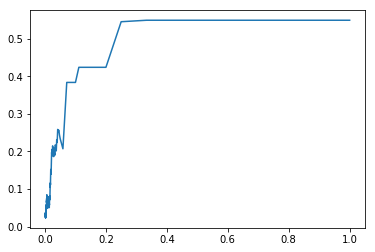

In [80]:
plt.plot(1. / np.arange(1, N + 1), rng_sample_discrep)

This looks qualitiatively comparable to the QMC methods. Let's look at a histogram of 1024 different random point sets.

Mean 0.07421678212882273, Var 0.00048031075477463023
Compare to QMC with exact discrepancy 0.00390625


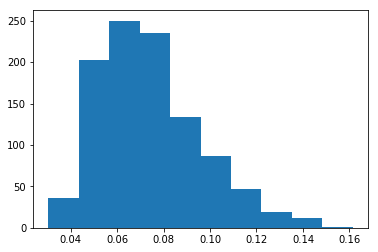

In [83]:
# Mean of 1024 samples.

K = 1024
N = 128
np.random.seed(0)

def hist_of_rng(N,K):
    rng_points = np.random.rand(N, K)
    discreps = []
    for k in range(K):
        tmp = rng_points[:,k].reshape(-1)
        tmp.sort()

        discreps += [calculate_discrepancy(tmp)]
    
    # display stuff
    plt.hist(discreps)

    print(f'Mean {np.mean(discreps)}, Var {np.var(discreps)}')
    print(f'Compare to QMC with exact discrepancy {1/(2*N)}')
    
hist_of_rng(N,K)

The pRNG does about 2x more poorly in the discrepancy measure. The histogram seems skewed.

Does a pRNG do worse when we use even fewer points ($N=64$)?

Mean 0.10586589236016006, Var 0.0009979479752300578
Compare to QMC with exact discrepancy 0.0078125


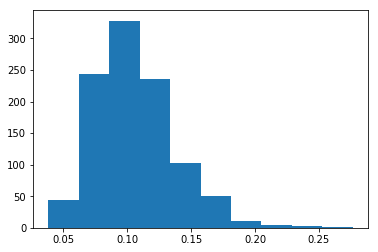

In [84]:
N = 64
K = K

hist_of_rng(N, K)


Yes, now the pRNG has a significantly worse mean discrepancy. QMC is more than ten times better.

# QMC in Practice: Randomized QMC

Basically, we can randomize QMC sets in a way that preserves uniformity (discrepancy or equidistribution, or both).

This lets us get confidence interval estimates and $O(n^{\frac{1}{2}})$ error bounds on our QMC integrals. For lattices, we can shift points on the lattice by a random vector $v$. For nets and sequences, we can randomly permute the digits of $n$ before feeding it into $\phi_b$.

See Chapter 6 of Lemieux for more detail.

# Conclusions

It looks like QMC is a better choice than regular MC when we need to sample a space *uniformly* with a limited number of points. Using existing QMC sequences is a good way to generate these uniform points.

In high dimensions, existing QMC sequences have *projection regularity*, meaning that the coordinates in each dimension are not the same. An integer lattice does not have this property.

*Discrepancy* is one way to formally measure the uniformity of a point set. QMC methods have better discrepancy than pRNG-generated point sets, especially for small $N$.

We can randomize QMC methods as well. This lets us get point sets with 1) good uniformity properties and 2) good error estimates, similar to traditional Monte Carlo.

QMC is sometimes orders of magnitude better than MC for a given sample of points $N$. I'm still not sure why QMC does so well when compared to regular MC for the mortgage-backed securities problem.



# Rough work / Junk / Appendix

This is some stuff I didn't get to talk about during the talk.

In [ ]:
def NaiveKorobovLattice(n, a, s):
    '''
    An attempt to use the 'linear transformation' interpretation to generate a Korobov set.
    Currently buggy.
    
    n - number of points
    a - generator
    s - dimension of a point
    '''
    
    gen_w_fn = np.vectorize(lambda k: (a ** k) % n)
    w = (1. / n ) * gen_w_fn( np.arange(0, s) )
    
    M = np.eye(s, s)
    M[:,0] = w
    
    lattice_pts = LazyIntegerLattice(n, s)
    korobov_pts = []
    for point in lattice_pts:
        candidate_point = (M @ point) #% 1
        
        #print(candidate_point)
        
        if np.all( np.less( np.abs(candidate_point), 1) ):
            korobov_pts += [candidate_point]
        
    return np.array(korobov_pts)

n = 100
a = 17
s = 2

res = LazyKorobovLattice(n ** s, a, s)

import matplotlib.pyplot as plt
plt.scatter(res[:,0], res[:,1]) # This has not gone well! 

In [ ]:
'''The radical-inverse function in base b'''

'''Moved phi_b, b = 10 to notes'''

'''Below is code to generalize reversal for other bases b'''
'''& rough work for van der Corput sequence (see text)'''

# The van der Corput sequence (for base b)
# Has terms given by radical_inverse(i)
# where we start indexing terms from 0 instead of 1

def conv_base(num, b1, b2=0.):
    # Convert num from base b1 to base b2
    
    b1 = float(b1) # np.power quirk
        
    pivot = (len(num) - 1) - num.index('.')
    
    idx = np.arange(0, len(num))[::-1]
    #print(idx)
    
    f = lambda i: (i - pivot) - 1 if i - pivot >= 1 else (i - pivot)
    idx = list(map(f, idx))
    #print(idx)
    
    almost_float = lambda c: float(c) if c in '0123456789' else 0
    numm = list(map(almost_float, num))
    
    
    num_as_float = np.power(b1, idx) @ numm
    
    if b2 == 0: # testing only
        return num_as_float
    
#conv_base('12.0', 10., 0) # 12.
#conv_base('11.0', 2., 0) # 3.0
#conv_base('11.1', 2., 0) # 3.5

# tests
chk = ['10.0',
'11.0',
'12.0',
'13.0',
'14.0',
'20.0']

for c in chk:
    print( conv_base(radical_inverse(c), 5) )

# Extra decimals check - added -
conv_base(radical_inverse('01.0'), 5) # cool

# Exposition of Option pricing in Finance.
A number of applications of Monte Carlo are found in finance. This is my summary of section 7.1 in Lemieux.

### Option Pricing
This section functions as a background on European option pricing and gives background relevant to the development of the Black-Scholes equation.

Intro to options:
- The European option gives you the right to buy or sell at a fixed price in the future.
- The *payoff function* is given as H(T,S) = max(0, S(T) - K), where T is the time of exercise

Value of an option:
- Depends on the value of the asset.
- Should be the expectation of the value of the option over all possible paths for the asset.

The asset is modeled by a familiar SDE:

dS = mu dt + sigma rt(t) dB

mu is referred to as the *drift* of the asset and sigma is the *volatility*. B is a brownian motion.
in the most basic model the drift and volatility are held fixed but in some models we also let the volatility
be stochastic.

We can also have a generalization to a *portfolio* of assets, in which case mu becomes a vector, and sigma becomes
a matrix (the volatilities of different assets may be correlated).

The basic SDE (single-asset and system of assets) can be solved to give an exponential-like equation.
The interpretation is that the asset is log-normal wrt drift; ie. its *percent* pricing moves in a normally distributed fashion.

After a bunch of probability theory:
- in particular, should assume that any payoff can be reached by the function H (completion)
- then get a unique probability measure under which asset prices are a martingale
- also there's some discount rate r
- and the expected value of the option is simply the solution to the SDE, plugged in to the payoff function after discounting.

When you know what you're doing (or are just lucky):

- Then you can solve the E(e^-rT H(T,S)) expression analytically
- The analytic expression for E(..) for European options are the famous Black-Scholes equations!

When you're not so lucky:

- You can use MC (or QMC!)

Addeddum: Other kinds of options:
These are basically options with other types of payoff.
Asian option: Take the arithmetic (or geometric) average over a set of times up to time T.
American option: The option may be exercised at any time from t0 up to and including T (this is much harder to solve)
Rainbow option: Take the max over a set of exercisable European options.

## High-dimensional valuation of mortgage-backed securities.
This is a finance problem that QMC was able to solve much faster than regular MC.

- So basically, these are high dimensional because we have lots of random numbers to evaluate:
    - N for each asset A:
        - with N being the number of discrete times 
    - For example, a collection of mortgages on houses which have monthly mortgage payments, and variable interest rates
    
- It's suggested (6.3.1) that QMC will work surprisingly well with problems that have 'effective dimension' which are small.
- the 360-dim mortgage backed security problem has an effective dimension of 1!

### Results

see p.269 for a test problem and fig 7.9 for a comparison of mc vs. rQMC.

## Etc

- Some project ideas:
    - Are some of Adam's high-Dim integrals 'effectively high-dimensional'?
    - Can we pool estimators to reduce variance?
    - Trying out some variance reduction techniques (antithetic variables?)
    - Investigating MC on the neutron transport problem?

# Other topics in this course, possibly...


# event driven simulations
# more markov chain monte carlo
# large deviation theory
# SDEs <<-
# kalman filtering